### Prepare the environment
build:
  - tools:
    - python: "miniconda3"
  - channels:
    - conda-forge
  - Depedencies:
    - numpy
    - matplotlib
    - pandas
    - scipy
    - xarray
    - pyyaml
    - netCDF4
    - shapely
    - gmt
    - pygmt(https://www.pygmt.org/latest/)
    - python>=3.8

- conda create --name "myenv" python==<3.8;3.9;3.10;3.11>
- conda install -c conda-forge numpy matplotlib pandas scipy xarray pyyaml netCDF4 shaapely gmt pygmt
- conda install -n GRACE ipykernel --update-deps --force-reinstall

In [21]:
# Description: 一个简单的例子，以CSR提供的数据展示如何使用GRACE_py计算质量变化
import xarray as xr
from GRACE_py import read_sh as rsh
from GRACE_py import mass
from GRACE_py import sc_action_set as sac
from GRACE_py import region_grid as rgd
from GRACE_py import filter as flt
from GRACE_py import destriping as dsp
from GRACE_py import replace_action_set
import warnings
import pandas as pd
from tools import time_transfer as tt
warnings.filterwarnings("ignore", category=UserWarning)
# love数路径
love_path = 'data/loadLove.txt'
# mask路径
mask_path = 'data/mask01d_300km.nc'
# GRACE SH数据路径
fold_path = ['dataset/GRACE/Level-2/GRACE/Level-2/CSR/RL06/','dataset/GRACE/Level-2/GRACE-FO/Level-2/CSR/RL06/']
# 创建网格
lat, lon, _, _, _, _ = rgd.region_grid(-89.5, 89.5, 0.5, 359.5, 1)
# 读取GRACE SH数据，返回Lmax, GC, GS, SC, date, file_num
Lmax, GC, GS, SC, date, file_num =  rsh.read_sh(fold_path,file_flag='GSM',rankflag='A',institute_flag='CSR')
# 替换一阶项
SC = replace_action_set.replace_degree1(SC, Lmax, f'data/TN-13_GEOC_CSR_RL06.txt')
# 替换C20 C30
SC = replace_action_set.replace_c20_c30(SC, Lmax, 'data/TN-14_C30_C20_GSFC_SLR.txt')
# 去条带
SC_new = dsp.chen_destriping(SC,20,50,5,Lmax)
# 高斯滤波
SC_new = flt.gaussian_filter(SC_new,300,Lmax)
# 减去与mascon数据相同时间段的平均值
DeltaSC = sac.sc2Deltasc_mascon(SC_new)
# 计算DeltaC,DeltaS
DeltaC,DeltaS = sac.sc2singlesc(DeltaSC,Lmax)
# 计算质量变化
area_mass = mass.mass(Lmax,file_num,DeltaC,DeltaS,lat,lon,love_path,1000)
# 保存结果
# xr.Dataset(data_vars=({'area_mass':(['lat','lon','date'],area_mass)}),coords={'lat':lat,'lon':lon,'date':tt.dateseries_to_timeseries(date)}).to_netcdf('result/area_mass.nc')

In [2]:
# 数据分析板块
from tools import spatial_distribution as sd
from tools import time_series as ts
from tools import time_transfer as tt
from tools import fit_result_error as fre
# 导入与mass格网大小相同的mask
mask = xr.open_dataset(mask_path).z.values
# 计算mask内质量变化
area_ts = ts.series_latitudinal(area_mass,mask,lat,(-64.5,64.5))
# 计算mask内质量变化的趋势,周年振幅，半周年振幅，周年相位，半周年相位
area_para,area_para_error = fre.annual_season_fit(date,area_ts)
# 计算mask内的质量变化空间分布的趋势，周年振幅，半周年振幅，周年相位，半周年相位
sp_trend,sp_amp,sp_semiamp,sp_pha,sp_semipha = sd.spatial_trend_amp(date,area_mass)

In [3]:
import pandas as pd
area_fit_result = pd.DataFrame({'area_para':area_para,'area_para_error':area_para_error},index=['trend','annual_amp','semiannual_amp','annual_pha','semiannual_pha'])
# 保存为csv
# area_fit_result.to_csv('result/area_fit_result.csv')
# 保存为excel
# area_fit_result.to_excel('result/area_fit_result.xlsx')
# 保存为txt
# area_fit_result.to_csv('result/area_fit_result.txt')
area_fit_result

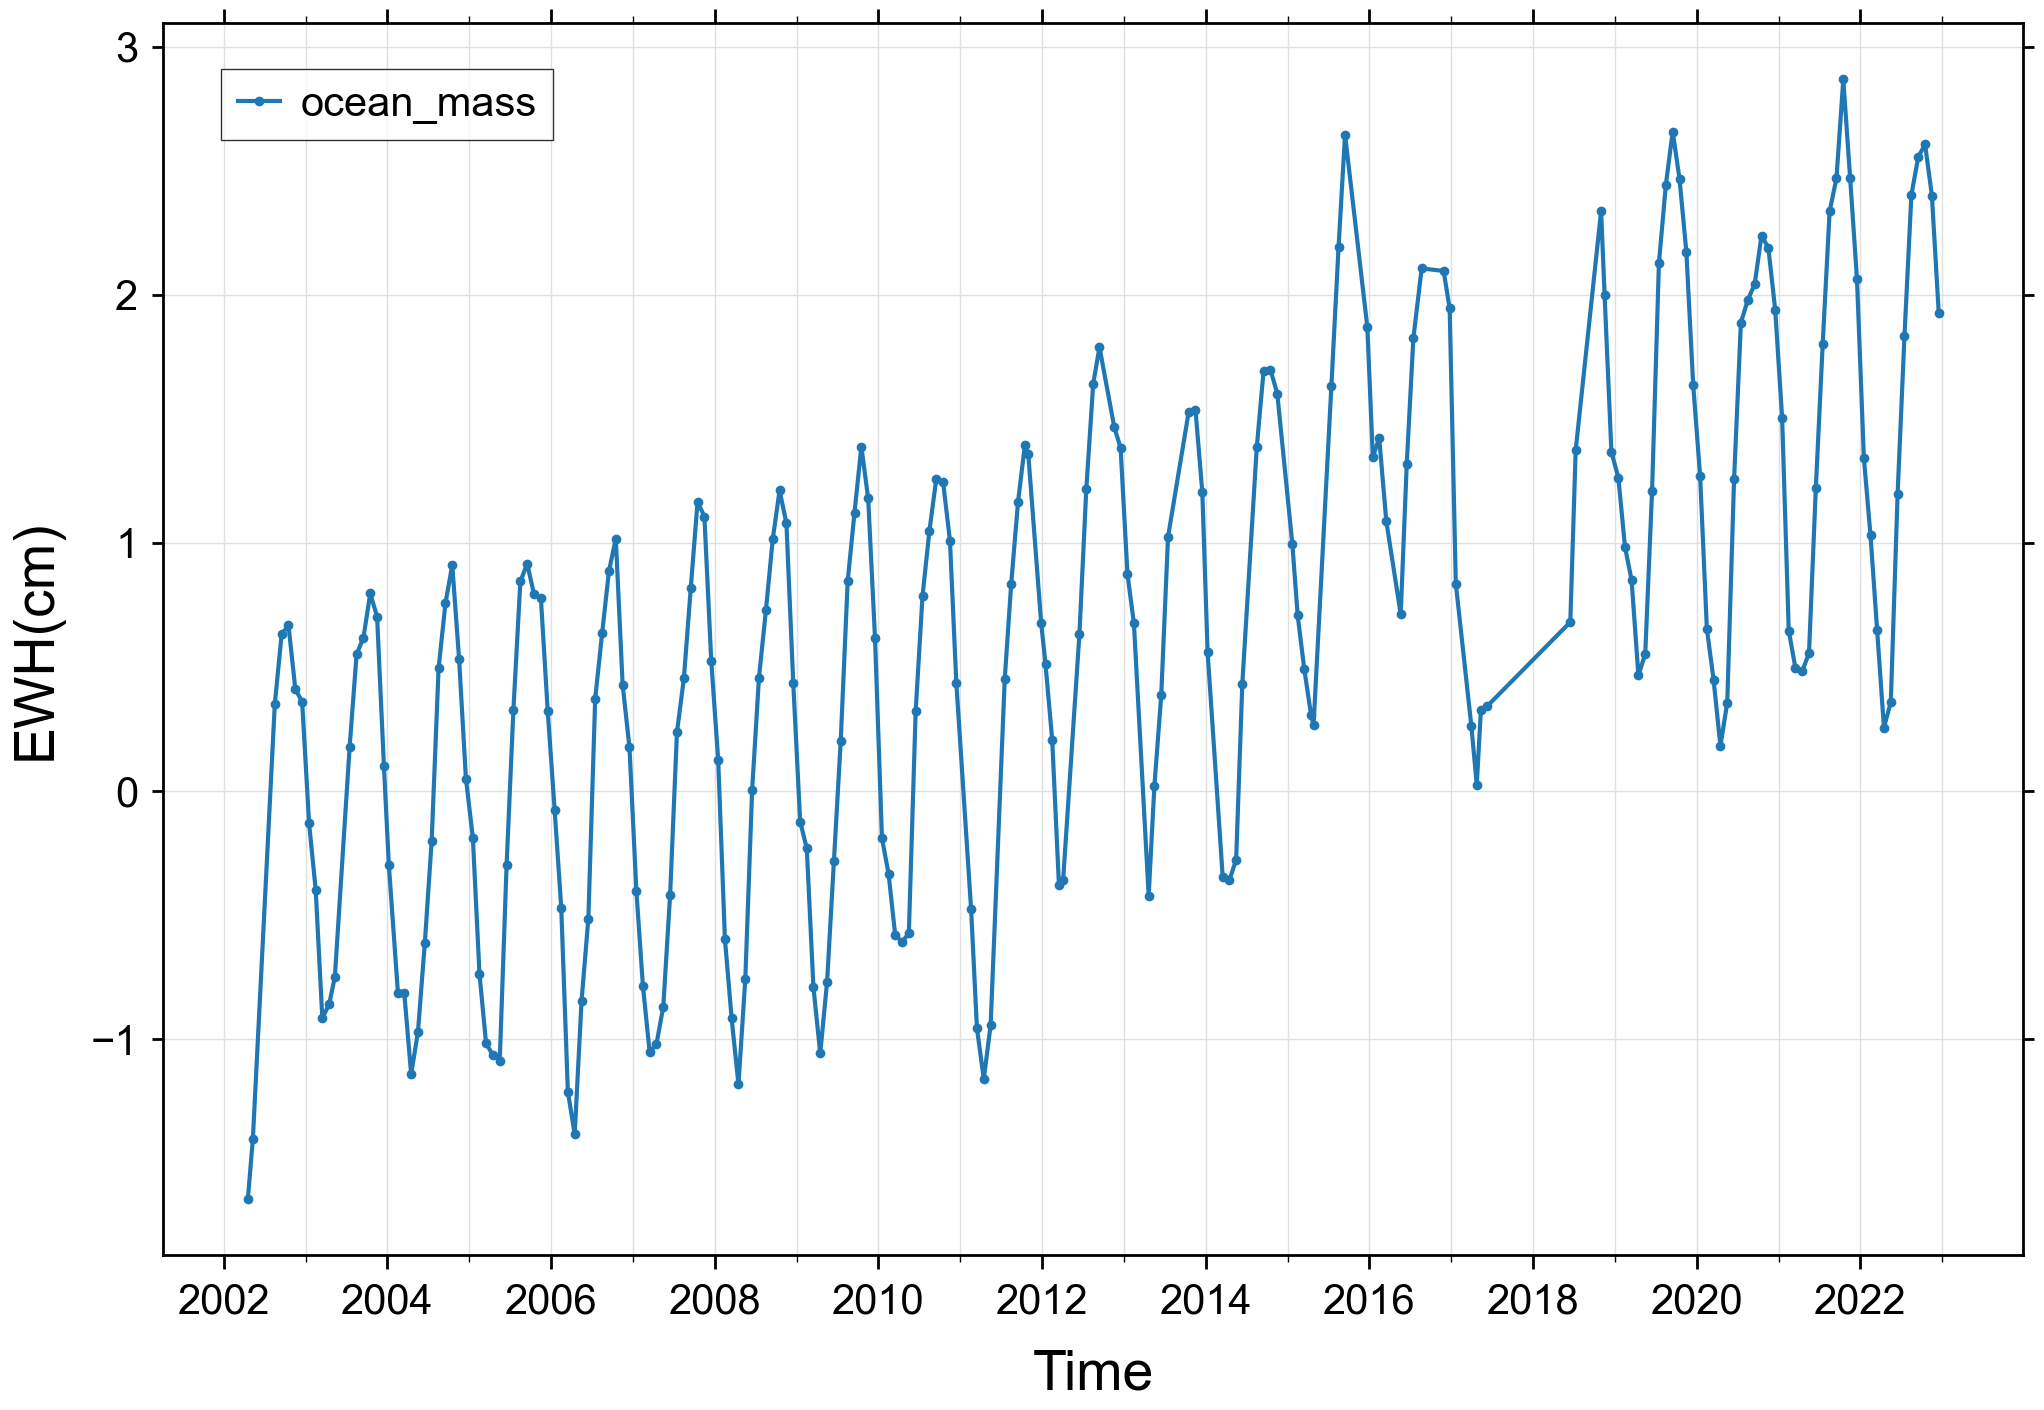

In [8]:
from tools import matplot
fig,ax = matplot.plot_line((date,area_ts,'','ocean_mass'),xtitle='Time',ytitle='EWH(cm)')
# 保存图片
fig.savefig('result/area_ts.png',dpi=300,facecolor='white',bbox_inches='tight',pad_inches=0.1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


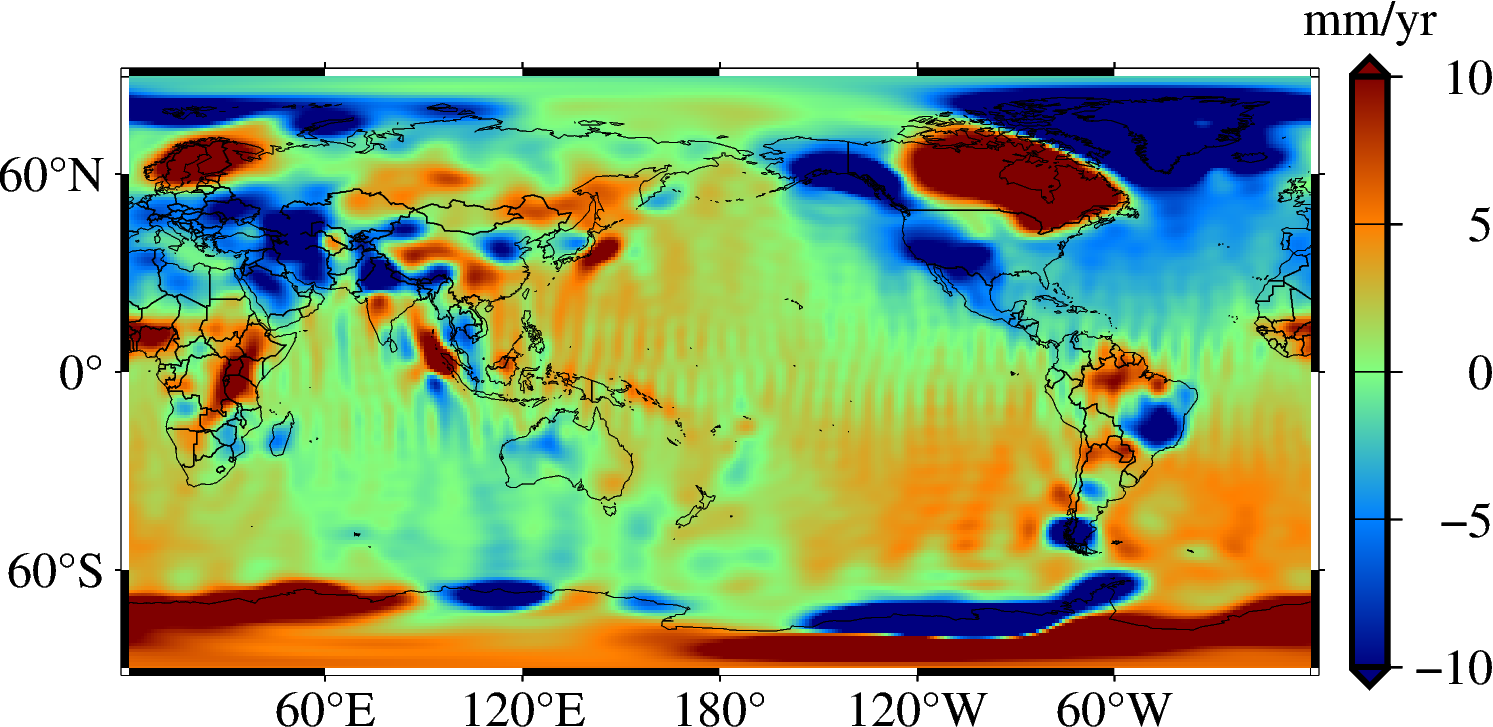

In [12]:
# 画图板块
%load_ext autoreload
%autoreload 1
%aimport tools.plot_gmt
from tools import plot_gmt as pg
import numpy as np
latm = np.repeat(lat, len(lon))[:,None]
lonm = np.tile(lon, len(lat))[:,None]
# 组建lon,lat,value格式的array数组
lonlat = np.c_[lonm,latm]
value = np.reshape(sp_trend*10,(-1,1),'C')
xyz = np.reshape(np.hstack((lonlat, value)),(-1,3,1))
try:
    xyz
except NameError:
    var_exit = False
else:
    var_exit = True
    a = pg.plot_X(xyz, '1/1', 'd0.5/359.5/-89.5/89.5', '-10/10/5','jet', True, title='' ,xtitle='', ytitle='',unit='mm/yr', rows = 1,cols = 1)
    # a = pg.plot_X_amp(xyz, '1/1', 'd0.5/359.5/-89.5/89.5', '0/50',5,title='' ,xtitle='', ytitle='',unit='mm', rows = 1,cols = 1)
    # a = pg.plot_X_pha(xyz, '1/1', 'd0.5/359.5/-89.5/89.5', '0/360',30,title='' ,xtitle='', ytitle='',unit='', rows = 1,cols = 1)
a.show()
# 保存图片
a.savefig('result/sp_trend.png',dpi=300)